In [1]:
# Uncomment line below to install exlib
# !pip install exlib
# !pip install diskcache
import sys; sys.path.insert(0, "../../exlib/src")
import exlib

ROOT_DIR = '..'

In [2]:
import torch
from datasets import load_dataset
from exlib.datasets.mass_maps import MassMapsDataset

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/runai-home/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s] 


In [3]:
# Load data
train_dataset = MassMapsDataset(split="train")
val_dataset = MassMapsDataset(split="validation")

In [4]:
import openai
from getpass import getpass
import os

with open(f"{ROOT_DIR}/API_KEY.txt", "r") as file:
    api_key = file.read().strip()

os.environ['OPENAI_API_KEY'] = api_key
os.environ['CACHE_DIR'] = os.path.join(ROOT_DIR, 'cache_dir')

# openai.api_key = getpass('Enter your OpenAI API key: ')
# os.environ['OPENAI_API_KEY'] = openai.api_key

In [5]:
from massmaps import MassMapsExample
from massmaps import massmap_to_pil_norm, get_llm_generated_answer
from massmaps import isolate_individual_features, distill_relevant_features, calculate_expert_alignment_score

# Get Few-shot Examples

In [ ]:
train_dataset['label'].min(dim=0), train_dataset['label'].max(dim=0)

In [ ]:
few_shot_numbers = [0, 1, 14, 19]

In [ ]:
for i in range(20):
    print(i, train_dataset['label'][i])

In [ ]:
from massmaps import massmap_to_pil_norm
import matplotlib.pyplot as plt

relevance_few_shot_examples = []
for i, idx in enumerate(few_shot_numbers):
    X, y = train_dataset[idx:idx+1]['input'], train_dataset[idx:idx+1]['label']
    relevance_few_shot_examples.append({'idx': idx, 'X': X, 'y': y})
    plt.figure()
    plt.imshow(massmap_to_pil_norm(X[0]))
    plt.axis('off')
    # plt.title(f'$\Omega_m$ {round(y[0][0].item(), 4)},   $\sigma_8$ {round(y[0][1].item(), 4)}')
    plt.savefig(os.path.join(ROOT_DIR, f'src/prompts/massmaps_relevance_few_shot_examples.{i}.Omega{round(y[0][0].item(), 4)}.sigma{round(y[0][1].item(), 4)}.png'), 
                dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

In [ ]:
relevance_few_shot_examples[0].update({
    'claim': 'The dataset represents the spatial distribution of matter density in the universe.',
    'relevance_answer': 'NO',
    'relevance_explanation': 'This is a general statement and does not justify any specific prediction.'
})
relevance_few_shot_examples[1].update({
    'claim': 'The weak lensing map shows several yellow pixels close to each other on the left side, suggesting the existence of high-density regions or clusters.',
    'relevance_answer': 'YES',
    'relevance_explanation': 'This is a specific cosmological structure observable in the data and indicative of cosmological parameters such as sigma_8.'
})
relevance_few_shot_examples[2].update({
    'claim': 'Voids are large low density regions in space.',
    'relevance_answer': 'NO',
    'relevance_explanation': 'This is background knowledge, not derived from the data.'
})
relevance_few_shot_examples[3].update({
    'claim': 'There is a gray pixel in the upper left corner with value 6.2992e-04 in the data.',
    'relevance_answer': 'NO',
    'relevance_explanation': 'Simply listing pixel values does not explain a prediction.'
})

In [ ]:
import torch

torch.save({
    'split': 'train',
    'examples': relevance_few_shot_examples
}, 'few_shot_examples/massmaps/relevance_examples.pt')


# Experiments

In [ ]:
# import torch

# relevance_few_shot_examples_path = 'few_shot_examples/massmaps/relevance_examples.pt'
# relevance_few_shot_examples = torch.load(relevance_few_shot_examples_path)['examples']

In [ ]:
# len(relevance_few_shot_examples), relevance_few_shot_examples[0]

In [6]:
from tqdm.auto import tqdm

massmaps_examples = []
for idx in tqdm(range(2)):
    X, y = val_dataset[idx:idx+1]['input'], val_dataset[idx:idx+1]['label']
    image = X[0]
    label = y[0]
    llm_answer, llm_explanation = get_llm_generated_answer(image)
    # rating, explanation = get_llm_generated_answer(row['Utterance'])
    if llm_answer is None:
        continue
    massmaps_examples.append(MassMapsExample(
        input=image,
        answer={"Omega_m": label[0].item(), "sigma_8": label[1].item()},
        llm_answer=llm_answer,
        llm_explanation=llm_explanation
    ))

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
for example in massmaps_examples:
    claims = isolate_individual_features(example.llm_explanation)
    if claims is None:
        continue
    example.claims = [claim.strip() for claim in claims]

In [8]:
massmaps_examples[0].claims

['The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean.',
 'The presence of numerous red and yellow regions suggests a significant number of high-density areas, indicating galaxy clusters.',
 'The yellow regions, in particular, represent areas above 3 standard deviations, confirming the presence of clusters.',
 'The blue areas indicate voids, where the matter density is significantly lower.',
 'The balance between these voids and clusters can provide insights into the cosmological parameters Omega_m and sigma_8.',
 'A higher density of clusters (yellow and red regions) suggests a higher value of sigma_8, which measures the amplitude of matter fluctuations.',
 'The distribution and size of voids and clusters also inform Omega_m, the matter density parameter.',
 'Given the substantial presence of clusters and moderate voids, this map suggests a relatively high Omega_m and sigma_8.',
 'A relatively high Omeg

In [9]:
for example in massmaps_examples:
    relevant_claims = distill_relevant_features(
        example.input, 
        example.llm_answer,
        example.claims
    )
    example.relevant_claims = relevant_claims

In [10]:
massmaps_examples[0].relevant_claims

['The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean.',
 'The presence of numerous red and yellow regions suggests a significant number of high-density areas, indicating galaxy clusters.',
 'The yellow regions, in particular, represent areas above 3 standard deviations, confirming the presence of clusters.',
 'The blue areas indicate voids, where the matter density is significantly lower.',
 'The balance between these voids and clusters can provide insights into the cosmological parameters Omega_m and sigma_8.',
 'A higher density of clusters (yellow and red regions) suggests a higher value of sigma_8, which measures the amplitude of matter fluctuations.',
 'The distribution and size of voids and clusters also inform Omega_m, the matter density parameter.',
 'Given the substantial presence of clusters and moderate voids, this map suggests a relatively high Omega_m and sigma_8.',
 'A relatively high Omeg

In [13]:
for example in massmaps_examples:
    alignment_scores = []
    alignment_categories = []
    for claim in tqdm(example.relevant_claims):
        category, alignment_score, reasoning = calculate_expert_alignment_score(example.input, example.llm_answer, claim)
        if category is None:
            continue
        alignment_scores.append(alignment_score)
        alignment_categories.append(category)
    example.alignment_scores = alignment_scores
    example.expert_criteria = alignment_categories
    example.alignment_reasonings = reasoning

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
for i in range(len(massmaps_examples)):
    for j 
    print(i, massmaps_examples[i].alignment_scores, example.expert_criteria)

0 [0.4, 0.8, 0.8, 0.8, 0.7, 0.8, 0.8, 0.7, 0.4] ['Density Contrast Extremes', 'Lensing Peak (Cluster) Abundance', 'Lensing Peak (Cluster) Abundance', 'Density Contrast Extremes', 'Void Size and Frequency', 'Density Contrast Extremes', 'Connectivity of the Cosmic Web', 'Density Contrast Extremes', 'Connectivity of the Cosmic Web', 'Lensing Peak (Cluster) Abundance']
1 [0.4, 0.8, 0.7, 0.4, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7] ['Density Contrast Extremes', 'Lensing Peak (Cluster) Abundance', 'Lensing Peak (Cluster) Abundance', 'Density Contrast Extremes', 'Void Size and Frequency', 'Density Contrast Extremes', 'Connectivity of the Cosmic Web', 'Density Contrast Extremes', 'Connectivity of the Cosmic Web', 'Lensing Peak (Cluster) Abundance']


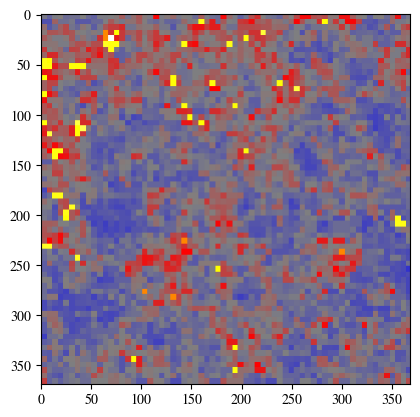

--- Answer ---
{'Omega_m': 0.1845703125, 'sigma_8': 0.9883788824081421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of numerous red and yellow regions suggests a significant number of high-density areas, indicating galaxy clusters. The yellow regions, in particular, represent areas above 3 standard deviations, confirming the presence of clusters. The blue areas indicate voids, where the matter density is significantly lower. The balance between these voids and clusters can provide insights into the cosmological parameters Omega_m and sigma_8. A higher density of clusters (yellow and red regions) suggests a higher value of sigma_8, which measures the amplitude of matter fluctuations. The distribution and size of voids and clusters also inform Omega_m, the matter density parameter. Given the substant

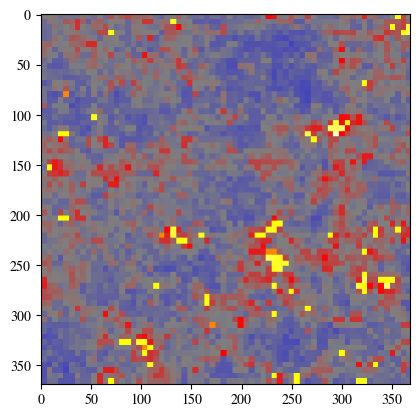

--- Answer ---
{'Omega_m': 0.10371093451976776, 'sigma_8': 1.190527319908142}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of yellow and white regions suggests significant matter overdensities, indicating galaxy clusters. These clusters are more frequent and prominent, suggesting a higher matter density in the universe. The red regions, which are less dense than the yellow and white but still above average, indicate areas of moderate overdensity. The blue regions represent voids, areas with lower matter density. The balance between these voids and clusters can help infer cosmological parameters. A higher frequency of clusters compared to voids suggests a higher Omega_m, indicating a universe with more matter. The presence of significant structures also suggests a higher sigma_8, indicating more pron

In [20]:
import matplotlib.pyplot as plt

for i in range(len(massmaps_examples)):
    plt.figure()
    plt.imshow(massmap_to_pil_norm(massmaps_examples[i].input))
    plt.show()
    print('==============')
    print('--- Answer ---')
    print(massmaps_examples[i].answer)
    print('--- LLM Pred Answer ---')
    print(massmaps_examples[i].llm_answer)
    print('--- LLM Pred Explanation ---')
    print(massmaps_examples[i].llm_explanation)
    print('--- Claims ---')
    print(massmaps_examples[i].claims)
    
    print('--- Scores (original (s + c), deepresesarch (s + c), claim) ---')
    for j in range(len(massmaps_examples[i].relevant_claims)):
        print(massmaps_examples[i].alignment_scores[j], 
              massmaps_examples[i].expert_criteria[j], '|',
              massmaps_examples[i].relevant_claims[j])
    # print('--- Relevant Claims ---')
    # print(massmaps_examples[i].relevant_claims)
    # print('--- Alignment Scores Original ---')
    # if massmaps_examples[i].alignment_scores == massmaps_examples_deepresearch[i].alignment_scores:
    #     same += 1
    # elif massmaps_examples[i].alignment_scores > massmaps_examples_deepresearch[i].alignment_scores:
    #     old_high += 1
    # else:
    #     new_high += 1
# print(same, old_high, new_high)

In [27]:
for i in range(len(massmaps_examples_deepresearch)):
    print(i, massmaps_examples_deepresearch[i].alignment_scores)

0 [4, 5, 5, 4, 3]
1 [4, 4, 5, 4, 5]
2 [3, 4, 5]
3 [3, 4, 5, 4, 5, 5]
4 [4, 5, 5, 5, 5]
5 [4, 5, 5, 5, 5, 4]
6 [4, 5, 5, 4, 5, 5]
7 [5, 4, 5, 4, 4]
8 [4, 4, 3, 5, 5, 4]
9 [5, 4, 5]
10 [5, 4, 5, 5]
11 [4, 2, 5, 5]
12 [4, 5, 5, 3, 2]
13 [4, 4, 5, 5]
14 [4, 5, 2, 4, 5, 3]
15 [4, 5, 3, 3, 5]
16 [3, 5, 5, 3, 1, 1]
17 [4, 4, 5, 4, 5, 4]
18 [3, 4, 5, 4]
19 [4, 5, 3, 3, 5, 3]


In [25]:
import json
save_dir = '_dump/massmaps'
os.makedirs(save_dir, exist_ok=True)
for i in tqdm(range(len(massmaps_examples))):
    save_dict = {}
    for k, v in massmaps_examples[i].__dict__.items():
        save_dict[k] = v if not isinstance(v, torch.Tensor) else v.cpu().numpy().tolist()
    with open(os.path.join(save_dir, f'{i}.json'), 'wt') as output_file:
        json.dump(save_dict, output_file)

  0%|          | 0/2 [00:00<?, ?it/s]